In [1529]:

import tganalysis
import os
import emoji
import pandas as pd

paths = ['C:/Users/mk/Downloads/Telegram Desktop/ChatExport_2023-12-23 (1)']

filename = os.path.join('data', paths[0], 'result.json')


In [1530]:

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)


In [1531]:
tg = tganalysis.tg_json_analysis(filename)
data = tg.df
data

{555167: msg(id=555167, type='message', date='2023-10-01T00:02:43', from_name='Валерий', from_id='user494565919', reply_to_message_id=555164, text='Да нет, все четко ! Проверил', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=0, td_idf=None),
 555169: msg(id=555169, type='message', date='2023-10-01T00:03:33', from_name='Алёна', from_id='user976033668', reply_to_message_id=None, text='Всем привет! Кто закрывал  сотрудничество с Вайлдберриз?', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=0, td_idf=None),
 555170: msg(id=555170, type='message', date='2023-10-01T00:03:41', from_name='Валерий', from_id='user494565919', reply_to_message_id=None, text='Да и когда поставку делал , там литраж ведь пишется напротив каждого артикула !', words=None, year=2023, month=10, day=1, week=39, weekday=7, hour=0, td_idf=None),
 555173: msg(id=555173, type='message', date='2023-10-01T00:04:04', from_name='Ирина', from_id='user462883553', reply_to_message_id=555163, text

In [1532]:
# data[522845].text
# text = data[522835].text


docs = list()

for dp in data:
    text = data[dp].text
    text = emoji.replace_emoji(text, lambda a,_:f".{a}. ")
    text = text.replace(') ', "). ")
    text = text.replace('\n', "\n. ")
    text = '. '.join([a.capitalize() for a in text.split('. ')])
    try:
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        doc.parse_syntax(syntax_parser)
        for token in doc.tokens:
            token.lemmatize(morph_vocab)
        docs.append({'id': dp, 'from_name': data[dp].from_id, 'doc': doc})
    except:
        pass
    




In [1533]:
# text = 'Мне алоэ плоховато распутывает и не очень делал волосы скользкими, хотя обычно у меня такой проблемы нет, в итоге получался очень большой расход'
# text = emoji.replace_emoji(text, lambda a,_:f".{a}. ")
# text = text.replace(') ', "). ")
# text = text.replace('\n', "\n. ")
# text = '. '.join([a.capitalize() for a in text.split('. ')])
# doc = Doc(text)
# doc.segment(segmenter)
# doc.tag_morph(morph_tagger)
# doc.parse_syntax(syntax_parser)
# for token in doc.tokens:
#     token.lemmatize(morph_vocab)
# doc.tokens

In [1534]:
roots_all = []
for doc_index, doc in enumerate(docs):
    for sent_index, sent in enumerate(doc['doc'].sents):
        roots = dict()
        for token in sent.tokens:
            if (token.rel == 'root') and (token.pos == 'VERB'):
                if not token.id in roots:
                    roots[token.id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.id]['root'] = token
            if token.rel == 'obj':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['obj'] = token
            if token.rel == 'nsubj':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['nsubj'] = token
            if token.rel == 'advmod':
                try:
                    root_token = sent.tokens[int(token.head_id[2:])-1]
                except:
                    root_token = sent.tokens[int(token.head_id[3:])-1]
                if not (root_token.rel == 'root' and root_token.pos == 'VERB'):
                    continue
                if not token.head_id in roots:
                    roots[token.head_id] = {'doc_index': doc_index, 'sent_index': sent_index}
                roots[token.head_id]['advmod'] = token
        if roots:
            roots_all.append(roots)                
        # print(roots)
        # break


In [1555]:
df = list()
for roots in roots_all:
    for root_id, root in roots.items():
        from_name = docs[root['doc_index']]['from_name']
        msg_id = docs[root['doc_index']]['id']
        d = {'from_name': from_name, 'msg_id': msg_id}
        try:
            d['advmod'] = root['advmod'].lemma
        except:
            pass
        try:
            d['root'] = root['root'].lemma
        except:
            pass
        try:
            d['nsubj'] = root['nsubj'].lemma
        except:
            pass
        try:
            d['obj'] = root['obj'].lemma
        except:
            pass
        df.append(d)
    # break
# doc[roots]

df = pd.DataFrame(df)
df_orig = df.copy()

# df


In [1556]:
names = df[['from_name', 'msg_id']].groupby('from_name').count()['msg_id']
names = names[names > 10]
names

from_name
channel1308157527     50
user1000240414        24
user1004047085        30
user1006563324        14
user1011622077        16
                    ... 
user935074356        125
user941089342         33
user948043930         16
user967346302         13
user997199517         35
Name: msg_id, Length: 259, dtype: int64

In [1557]:
df = df.fillna('').groupby(['from_name', 'nsubj', 'advmod', 'root', 'obj']).count().reset_index().set_index('from_name')
# df

In [1558]:
df = df[df.index.isin(names.index)]
df.loc[:,'msg_id'] = df['msg_id']/names
# df.sort_values('msg_id', ascending=False).head(30)

C:\Users\mk\AppData\Local\Temp\ipykernel_13148\147400006.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02       0.06       0.02       ... 0.02857143 0.02857143 0.02857143]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'msg_id'] = df['msg_id']/names


In [1559]:
param = 'nsubj'


df[[param, 'msg_id']].groupby(param).count().sort_values('msg_id', ascending=False)

,msg_id
obj,
,4710
товар,119
это,49
что,45
весь,38
...,...
десятка,1
дешевизна,1
одинаковый,1


In [1560]:

nsubjs = df[[param, 'msg_id']].groupby(param).count().query('msg_id < 400 & msg_id > 1').sort_values('msg_id', ascending=False)
# .query('msg_id < 400 & msg_id > 3')
nsubjs


,msg_id
obj,
товар,119
это,49
что,45
цена,38
весь,38
...,...
сайт,2
рука,2
обновление,2


In [1561]:
df = df[df[param].isin(nsubjs.index)]
df

,nsubj,advmod,root,obj,msg_id
from_name,,,,,
channel1308157527,,,найти,знак,0.020000
channel1308157527,вы,,переплатить,%,0.060000
channel1308157527,москвич,,потерять,рубль,0.060000
channel1308157527,я,,подготовить,урок,0.060000
user1000240414,,,обсудить,вопрос,0.041667
...,...,...,...,...,...
user997199517,,не,перевести,мы,0.028571
user997199517,вб,,пропустить,текст,0.028571
user997199517,вы,,исключать,кластер,0.028571


In [1562]:
users_corr = df.pivot_table(index=param, columns='from_name', values='msg_id', aggfunc='sum').fillna(0).corr()
# users_corr = users_corr > 0
# users_corr = users_corr.corr()
users_corr# = users_corr[users_corr.index]

from_name,channel1308157527,user1000240414,user1004047085,user1011622077,user1019711626,user103092718,user1031153357,user1034758841,user1035412659,user1042393552,...,user874955453,user907649916,user917345302,user918848100,user918954907,user935074356,user941089342,user948043930,user967346302,user997199517
from_name,,,,,,,,,,,,,,,,,,,,,
channel1308157527,1.000000,-0.018418,-0.022668,-0.015912,-0.009142,0.065643,-0.021564,-0.014990,-0.012960,-0.026305,...,-0.018418,-0.022668,-0.021564,0.270285,-0.012960,-0.039108,-0.024545,-0.012960,-0.015912,-0.026870
user1000240414,-0.018418,1.000000,-0.024015,-0.016857,-0.009685,-0.021869,0.147676,0.398987,-0.013730,0.154143,...,-0.019512,-0.024015,-0.022845,-0.019512,-0.013730,0.291615,-0.026003,-0.013730,0.570328,-0.028466
user1004047085,-0.022668,-0.024015,1.000000,0.220148,-0.011921,-0.026915,0.251711,-0.019545,-0.016899,-0.034298,...,-0.024015,-0.029557,0.251711,-0.024015,-0.016899,-0.050993,0.127253,0.277423,-0.020747,-0.035035
user1011622077,-0.015912,-0.016857,0.220148,1.000000,-0.008367,-0.018893,-0.019736,-0.013719,0.401330,-0.024075,...,-0.016857,0.220148,0.176685,0.276736,-0.011862,0.251933,-0.022465,-0.011862,-0.014563,-0.024592
user1019711626,-0.009142,-0.009685,-0.011921,-0.008367,1.000000,-0.010855,-0.011340,-0.007883,-0.006816,-0.013833,...,-0.009685,-0.011921,-0.011340,-0.009685,-0.006816,-0.020566,-0.012907,-0.006816,-0.008367,-0.014130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user935074356,-0.039108,0.291615,-0.050993,0.251933,-0.020566,-0.046435,0.007196,0.169569,0.556744,0.178658,...,0.041830,0.290593,0.118605,0.208354,0.088025,1.000000,0.071597,-0.029155,0.251933,0.133906
user941089342,-0.024545,-0.026003,0.127253,-0.022465,-0.012907,-0.029144,0.359121,-0.021163,-0.018298,0.101467,...,-0.026003,0.127253,0.229266,-0.026003,-0.018298,0.071597,1.000000,0.254865,0.201112,0.188593
user948043930,-0.012960,-0.013730,0.277423,-0.011862,-0.006816,-0.015389,0.463894,-0.011175,-0.009662,-0.019610,...,-0.013730,-0.016899,0.463894,-0.013730,-0.009662,-0.029155,0.254865,1.000000,-0.011862,-0.020031


<Axes: xlabel='from_name', ylabel='from_name'>

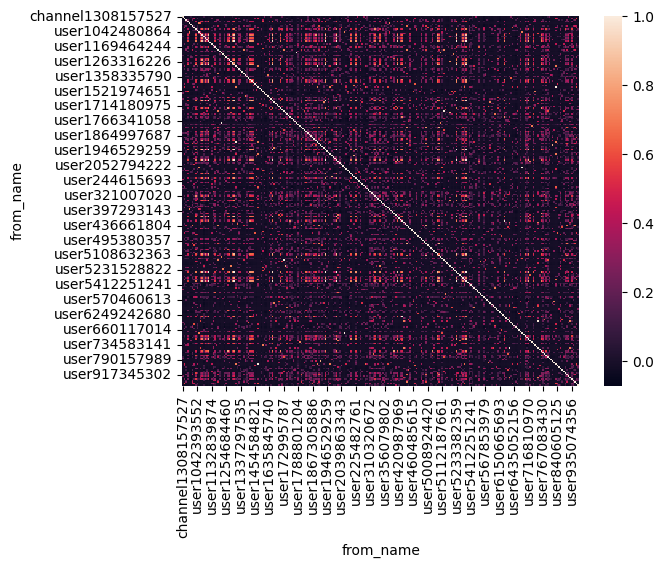

In [1563]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.figure()
c= users_corr
sns.heatmap(c)

8.127443708163373 len= 248 <0: 152


variable
user1123710435    0.183852
user5281012752    0.183852
user5233382359    0.183852
user2005471218    0.183852
user1284803741    0.183852
                    ...   
user2039863343   -0.011498
user967346302    -0.011562
user1034758841   -0.011944
user355762926    -0.012043
user778356860    -0.014727
Name: PC1, Length: 248, dtype: float64

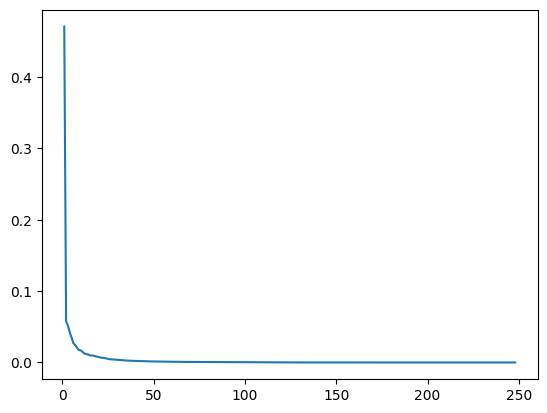

In [1564]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_out = PCA().fit(users_corr)

ev = pca_out.explained_variance_ratio_
plt.plot(range(1,users_corr.shape[1]+1),ev)

loadings = pca_out.components_
num_pc = len(users_corr)
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = users_corr.columns.values
loadings_df = loadings_df.set_index('variable').sort_values('PC1', ascending=False)
# loadings_df['PC1'].to_list()
print(ev[0]/ev[1], 'len=', len(loadings_df.loc[:,'PC1']), '<0:', sum(loadings_df.loc[:,'PC1'] < 0))
loadings_df.loc[:,'PC1']



In [1565]:
users_corr.loc[loadings_df.index.values[0], loadings_df.index.values[1]]

1.0000000000000002

In [1566]:
df.loc[loadings_df.index.values[-1], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).head(30)

,msg_id
obj,
деньга,0.045455
цена,0.030303
%,0.015152
заказ,0.015152
наклейка,0.015152
ничто,0.015152
описание,0.015152
остаток,0.015152
право,0.015152


In [1567]:
from collections import Counter
words = Counter()
for i in range(25):
    try:
        a = df_orig.set_index('from_name').loc[loadings_df.index.values[i], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).index.to_list()
        # a = df.loc[loadings_df.index.values[i], ['msg_id', param]].groupby(param).sum().sort_values('msg_id', ascending=False).index.to_list()
    except:
        pass
    words.update(a)

# [k for k, w in words.items() if w > 7]
pd.Series(words).sort_values(ascending=False).head(25)


товар       25
ответ        3
вы           3
отзыв        3
цена         2
возврат      2
отчет        2
поставка     2
остаток      2
выкуп        2
она          1
письмо       1
ввиду        1
тыс          1
хранение     1
объемный     1
спрос        1
баланс       1
акт          1
весь         1
штрих        1
замена       1
звезда       1
знак         1
рейтинг      1
dtype: int64

In [1568]:
# df.groupby(['nsubj', 'advmod', 'root','obj']).agg(['mean', 'count']).sort_values(('msg_id', 'mean'), ascending=False).to_clipboard(decimal=',')

In [1569]:
df[['msg_id', 'root', 'obj', 'nsubj', 'advmod']].groupby(['nsubj','advmod', 'root', 'obj',  ]).count().reset_index().sort_values('msg_id', ascending=False)
#.to_clipboard()
# .head(30)

,nsubj,advmod,root,obj,msg_id
60,,,делать,поставка,4
74,,,ждать,ответ,4
785,вы,,иметь,ввиду,3
1229,я,,понять,это,3
322,,,смотреть,товар,3
...,...,...,...,...,...
454,,не,бросить,товар,1
453,,не,брать,р,1
452,,напрямую,брать,товар,1
451,,наконец-то,прийти,отчет,1


In [1570]:
texts = pd.DataFrame(data).transpose()[[3, 4, 0, 6]].rename(columns={3:'from_name', 4:'from_id', 0: 'msg_id', 6:'text'}).set_index('msg_id')


In [1571]:
df_orig.query('nsubj == "водоросль" & root == "получаться"')
df_orig.query('nsubj == "диффузор" & root == "мочь"')
df_orig.query('nsubj == "банк"').groupby('root').count().sort_values('msg_id', ascending=False)

,from_name,msg_id,advmod,obj,nsubj
root,,,,,
дать,1,1,0,1,1
делать,1,1,0,0,1
завершиться,1,1,0,0,1
одобрять,1,1,1,1,1
открывать,1,1,1,1,1
отправлять,1,1,0,1,1
пользоваться,1,1,0,1,1
помогать,1,1,1,0,1
посчитать,1,1,0,0,1


In [1572]:
msg_ids = df_orig.query('nsubj == "банк"  & root == "быть"')['msg_id']
msg_ids

Series([], Name: msg_id, dtype: int64)

In [1573]:
texts[texts.index.isin(msg_ids)]['text'].to_clipboard()

In [1574]:
verb = 'мочь'
df.pivot_table(index='from_name', columns='root', values='msg_id', aggfunc='count')[[verb]].dropna().sort_values(verb, ascending=False)

root,мочь
from_name,
user1743422725,4.0
user1031153357,1.0
user431370235,1.0
user767083430,1.0
user734583141,1.0
user716810970,1.0
user697734697,1.0
user6249242680,1.0
user550667661,1.0
